# Version

- 개발환경 : windows10, python 3.8.5
- 라이브러리 버전 정보
- pandas : 1.4.4
- seaborn : 0.11.2
- scikit-learn : 1.1.2
- optuna : 3.1.0.dev0
- xgboost : 1.7.2
- catboost : 1.0.3
- lightgbm : 3.2.1

# Import

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np

#Utility
import random

# Preprocessing & Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile

# Evaluation
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

# Optuna
import optuna
from optuna.samplers import TPESampler
from optuna import Trial

# Modeling
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

pd.set_option('mode.chained_assignment',  None)

# Data load

In [2]:
filename = 'data/train.csv'
data_train = pd.read_csv(filename)

filename = 'data/test.csv'
data_test = pd.read_csv(filename)

filename = 'data/sample_submission.csv'
submission = pd.read_csv(filename)

# EDA

In [3]:
display(data_train.head())
display(data_train.info())
display(data_train.shape)
display(data_train.isna().sum().sum())

,ID,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,...,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
0,TRAIN_0000,692,275.0,287.0,292.0,289.5,2.8,2.8,2.7,2.7,...,70.978249,70.876794,70.705253,70.559603,70.427356,70.340491,70.293830,70.262422,70.169841,70.043251
1,TRAIN_0001,534,293.0,284.0,336.0,310.0,3.3,3.3,3.3,3.2,...,71.535483,71.382303,71.253604,71.092665,70.955608,70.796630,70.597550,70.565088,70.560502,70.427600
2,TRAIN_0002,634,300.0,392.0,450.0,421.0,3.0,2.9,2.9,2.9,...,71.279804,71.199570,71.144020,71.026740,70.920038,70.876723,70.710129,70.595971,70.418203,70.399578
3,TRAIN_0003,639,289.0,368.0,379.0,373.5,3.1,3.0,3.0,3.0,...,69.934615,69.884124,69.845683,69.794682,69.779813,69.614644,69.455404,69.281590,69.238689,69.133970
4,TRAIN_0004,496,306.0,353.0,358.0,355.5,3.7,3.6,3.6,3.6,...,68.313016,68.285364,68.209860,68.209458,68.040083,67.859963,67.775556,67.701456,67.504244,67.410093


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Columns: 184 entries, ID to 2022-11-28 엽록소
dtypes: float64(182), int64(1), object(1)
memory usage: 3.1+ MB


None

(2207, 184)

0

In [4]:
display(data_test.head())
display(data_test.info())
display(data_test.shape)
display(data_test.isna().sum().sum())

,ID,수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,...,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
0,TEST_0000,231.0,219.0,302.0,260.5,4.3,4.2,4.2,4.1,4.1,...,72.091497,71.906176,71.886799,71.858720,71.725540,71.531618,71.476935,71.321237,71.184295,71.000223
1,TEST_0001,206.0,324.0,346.0,335.0,2.5,2.5,2.5,2.5,2.5,...,68.423776,68.353200,68.346777,68.188159,67.995233,67.879958,67.744820,67.673522,67.539973,67.447849
2,TEST_0002,282.0,373.0,404.0,388.5,4.7,4.7,4.6,4.6,4.5,...,74.435783,74.247468,74.142664,74.070401,73.892408,73.796143,73.615838,73.440136,73.387051,73.228319
3,TEST_0003,234.0,337.0,357.0,347.0,3.6,3.6,3.6,3.6,3.5,...,73.570735,73.420243,73.313538,73.149298,73.109599,72.924511,72.847411,72.838263,72.672156,72.538171
4,TEST_0004,222.0,329.0,347.0,338.0,2.7,2.7,2.7,2.7,2.6,...,72.216758,72.163153,72.052952,71.905982,71.766141,71.746813,71.668847,71.501043,71.419715,71.328224


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2208 entries, 0 to 2207
Columns: 183 entries, ID to 2022-11-28 엽록소
dtypes: float64(182), object(1)
memory usage: 3.1+ MB


None

(2208, 183)

0

In [5]:
submission.head()

,ID,착과량(int)
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


## Target distribution

In [6]:
from collections import Counter

def print_mode(df, col):

  cnt = Counter(df[col])
  list_cnt = cnt.most_common(3)

  for idx, value in enumerate(list_cnt):

    print(f'{col}의 최빈값 {idx+1}순위 : {value[0]} & {value[-1]}개')

In [7]:
def print_statistics(df, col):

  max = df['착과량(int)'].max()
  min = df['착과량(int)'].min()
  mean = df['착과량(int)'].mean()
  median = df['착과량(int)'].median()

  print(f'{col}의 최대값 : {max}')
  print(f'{col}의 최소값 : {min}')
  print(f'{col}의 평균값 : {mean}')
  print(f'{col}의 중앙값 : {median}')
  print_mode(df, col)

In [8]:
def identify_hist(df, col):

  sns.histplot(data=df[col], kde=True)
  print_statistics(df, col)

착과량(int)의 최대값 : 799
착과량(int)의 최소값 : 1
착과량(int)의 평균값 : 406.22247394653374
착과량(int)의 중앙값 : 404.0
착과량(int)의 최빈값 1순위 : 300 & 9개
착과량(int)의 최빈값 2순위 : 231 & 9개
착과량(int)의 최빈값 3순위 : 632 & 9개


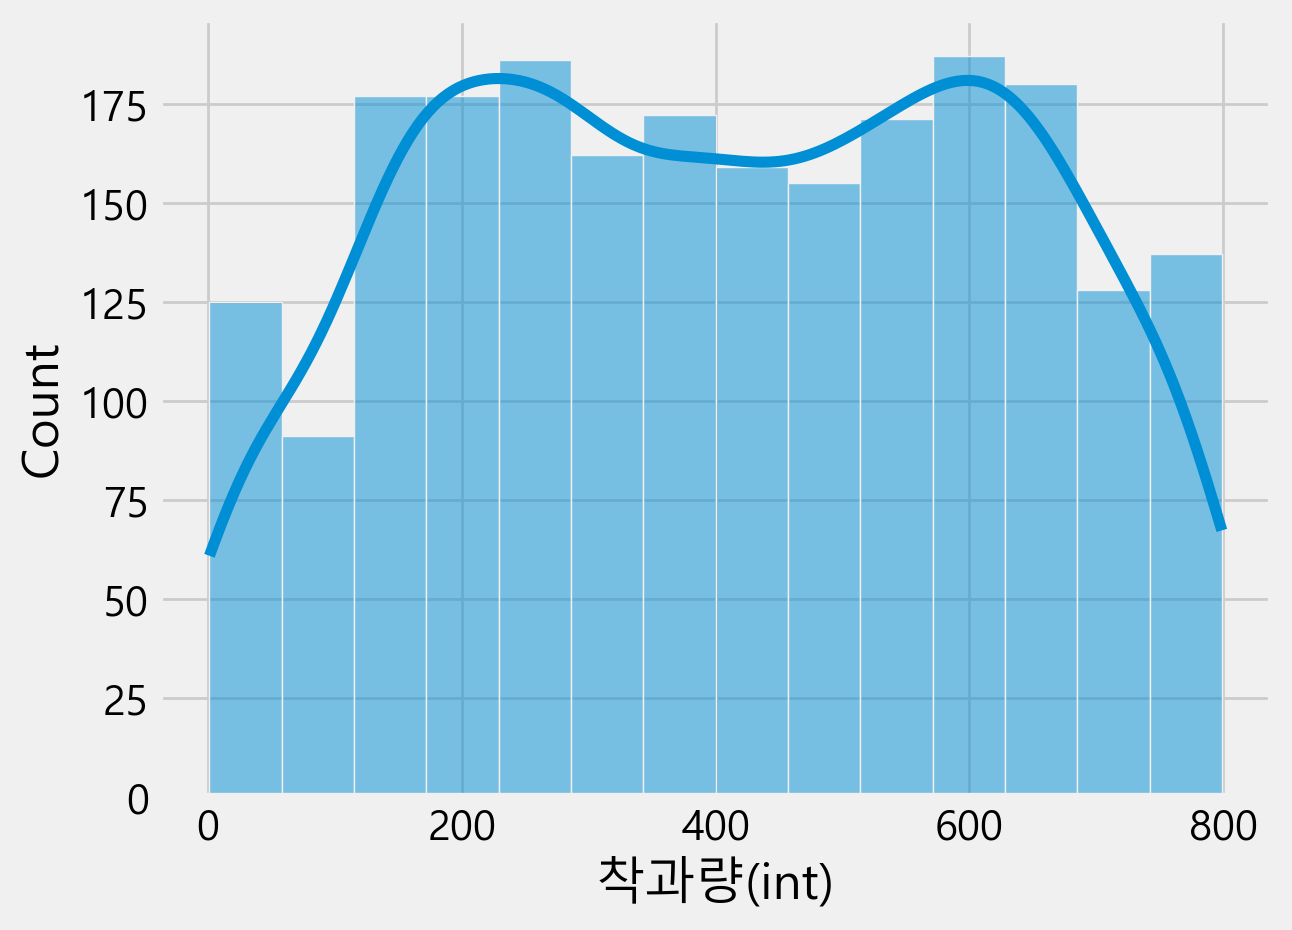

In [9]:
#시각화 설정
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

# 사용자 운영체제 확인
import os
os.name

# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

identify_hist(data_train, '착과량(int)')

# Data preprocessing + Feature Engineering

### Feature set_1

In [10]:
#train, target split
y_train = data_train['착과량(int)']
X_drop_list = ['ID']
X_train = data_train.drop(X_drop_list, axis = 1)
X_test = data_test.drop(["ID"], axis = 1)

In [11]:
#feature selection(target correlation limit)
high_corr = data_train.corr().abs().sort_values(by='착과량(int)',ascending=False).iloc[:,:1]
features_name = high_corr[high_corr['착과량(int)']>0.9].index
features_name = list(features_name)
features_name.remove('착과량(int)')
X,y = X_train.drop(['착과량(int)'], axis=1) , X_train['착과량(int)']

X_1 = X[features_name]
X_test_1 = X_test[features_name]

In [12]:
#이상치(outlier)처리
X_1 = X_1.apply(lambda x: x.clip(x.quantile(.01), x.quantile(.99)), axis=0)

### Feature set_2

In [13]:
#seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [14]:
X_train = X_train.drop(['착과량(int)'], axis=1)

In [15]:
X_train['9월_새순_mean'] = X_train.iloc[:,4:34].mean(axis = 1)
X_train['9월_새순_std'] = X_train.iloc[:,4:34].std(axis = 1)
X_train['9월_새순_var'] = X_train.iloc[:,4:34].var(axis = 1)
X_train['10월_새순_mean'] = X_train.iloc[:,34:65].mean(axis = 1)
X_train['10월_새순_std'] = X_train.iloc[:,34:65].std(axis = 1)
X_train['10월_새순_var'] = X_train.iloc[:,34:65].var(axis = 1)
X_train['11월_새순_mean'] = X_train.iloc[:,65:93].mean(axis = 1)
X_train['11월_새순_std'] = X_train.iloc[:,65:93].std(axis = 1)
X_train['11월_새순_var'] = X_train.iloc[:,65:93].var(axis = 1)
X_train['9월_엽록소_mean'] = X_train.iloc[:,93:123].mean(axis = 1)
X_train['9월_엽록소_std'] = X_train.iloc[:,93:123].std(axis = 1)
X_train['9월_엽록소_var'] = X_train.iloc[:,93:123].var(axis = 1)
X_train['10월_엽록소_mean'] = X_train.iloc[:,123:154].mean(axis = 1)
X_train['10월_엽록소_std'] = X_train.iloc[:,123:154].std(axis = 1)
X_train['10월_엽록소_var'] = X_train.iloc[:,123:154].var(axis = 1)
X_train['11월_엽록소_mean'] = X_train.iloc[:,154:182].mean(axis = 1)
X_train['11월_엽록소_std'] = X_train.iloc[:,154:182].std(axis = 1)
X_train['11월_엽록소_var'] = X_train.iloc[:,154:182].var(axis = 1)

In [16]:
X_train['새순max'] = X_train.iloc[:,4:93].max(axis=1)
X_train['새순min'] = X_train.iloc[:,4:93].min(axis=1)
X_train['엽록소max'] = X_train.iloc[:,93:182].max(axis=1)
X_train['엽록소min'] = X_train.iloc[:,93:182].min(axis=1)
X_train['새순차이'] = X_train['새순max']-X_train['새순min']
X_train['엽록소차이'] = X_train['엽록소max']-X_train['엽록소min']
X_train['수고X수관폭'] = X_train['수고(m)']*X_train['수관폭평균']
X_train['수관폭차이'] = X_train['수관폭2(max)']-X_train['수관폭1(min)']

In [17]:
for i in range(0,89):
    X_train[f'새순+엽록소_{i}'] = X_train.iloc[:,4:93].iloc[:,i]+X_train.iloc[:,93:182].iloc[:,i]
for i in range(0,89):
    X_train[f'새순-엽록소_{i}'] = X_train.iloc[:,4:93].iloc[:,i]-X_train.iloc[:,93:182].iloc[:,i]
for i in range(0,89):
    X_train[f'새순*엽록소_{i}'] = X_train.iloc[:,4:93].iloc[:,i]*X_train.iloc[:,93:182].iloc[:,i]
for i in range(0,89):
    X_train[f'새순/엽록소_{i}'] = X_train.iloc[:,4:93].iloc[:,i]/X_train.iloc[:,93:182].iloc[:,i]

In [18]:
X_test['9월_새순_mean'] = X_test.iloc[:,4:34].mean(axis = 1)
X_test['9월_새순_std'] = X_test.iloc[:,4:34].std(axis = 1)
X_test['9월_새순_var'] = X_test.iloc[:,4:34].var(axis = 1)
X_test['10월_새순_mean'] = X_test.iloc[:,34:65].mean(axis = 1)
X_test['10월_새순_std'] = X_test.iloc[:,34:65].std(axis = 1)
X_test['10월_새순_var'] = X_test.iloc[:,34:65].var(axis = 1)
X_test['11월_새순_mean'] = X_test.iloc[:,65:93].mean(axis = 1)
X_test['11월_새순_std'] = X_test.iloc[:,65:93].std(axis = 1)
X_test['11월_새순_var'] = X_test.iloc[:,65:93].var(axis = 1)
X_test['9월_엽록소_mean'] = X_test.iloc[:,93:123].mean(axis = 1)
X_test['9월_엽록소_std'] = X_test.iloc[:,93:123].std(axis = 1)
X_test['9월_엽록소_var'] = X_test.iloc[:,93:123].var(axis = 1)
X_test['10월_엽록소_mean'] = X_test.iloc[:,123:154].mean(axis = 1)
X_test['10월_엽록소_std'] = X_test.iloc[:,123:154].std(axis = 1)
X_test['10월_엽록소_var'] = X_test.iloc[:,123:154].var(axis = 1)
X_test['11월_엽록소_mean'] = X_test.iloc[:,154:182].mean(axis = 1)
X_test['11월_엽록소_std'] = X_test.iloc[:,154:182].std(axis = 1)
X_test['11월_엽록소_var'] = X_test.iloc[:,154:182].var(axis = 1)

In [19]:
X_test['새순max'] = X_test.iloc[:,4:93].max(axis=1)
X_test['새순min'] = X_test.iloc[:,4:93].min(axis=1)
X_test['엽록소max'] = X_test.iloc[:,93:182].max(axis=1)
X_test['엽록소min'] = X_test.iloc[:,93:182].min(axis=1)
X_test['새순차이'] = X_test['새순max']-X_test['새순min']
X_test['엽록소차이'] = X_test['엽록소max']-X_test['엽록소min']
X_test['수고X수관폭'] = X_test['수고(m)']*X_test['수관폭평균']
X_test['수관폭차이'] = X_test['수관폭2(max)']-X_test['수관폭1(min)']

In [20]:
for i in range(0,89):
    X_test[f'새순+엽록소_{i}'] = X_test.iloc[:,4:93].iloc[:,i]+X_test.iloc[:,93:182].iloc[:,i]
for i in range(0,89):
    X_test[f'새순-엽록소_{i}'] = X_test.iloc[:,4:93].iloc[:,i]-X_test.iloc[:,93:182].iloc[:,i]
for i in range(0,89):
    X_test[f'새순*엽록소_{i}'] = X_test.iloc[:,4:93].iloc[:,i]*X_test.iloc[:,93:182].iloc[:,i]
for i in range(0,89):
    X_test[f'새순/엽록소_{i}'] = X_test.iloc[:,4:93].iloc[:,i]/X_test.iloc[:,93:182].iloc[:,i]

In [21]:
X_train.shape, X_test.shape

((2207, 564), (2208, 564))

### Metric definition

In [22]:
#base version
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

#cross_val custom version
def NMAE_CV(clf, x, y):
    pred = clf.predict(x)
    mae = np.mean(np.abs(y - pred))
    score = mae / np.mean(np.abs(y))
    return score

In [23]:
NFOLDS = 10
SEED = 22

In [24]:
numeric_features = list(X_train.columns)

In [25]:
#pipeline을 이용한 preprocessing
def remove_outlier(X, q=0.02):  
    df = pd.DataFrame(X)
    return df.apply(lambda x: x.clip(x.quantile(q), x.quantile(1-q)), axis=0).values

numeric_transformer = Pipeline(
    steps=[
        ("outlier", FunctionTransformer(remove_outlier, kw_args={'q':0.02})), 
        ("scaler", MinMaxScaler()),
    ]
)
 
column_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
   ]
)

preprocessor = Pipeline(
    steps=[
        ("column", column_transformer), 
    ]
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("Regressor", LGBMRegressor(objective="regression", metric="mae", random_state=SEED)),
    ]
)

In [26]:
#최적값으로 파이프라인 재설정(optuna를 이용해 preprocessing parameter tuning)
model.set_params(preprocessor__column__num__outlier__kw_args =  {'q': 0.02}, preprocessor__column__num__scaler = MinMaxScaler())

#전처리 파이프라인만 수행
X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

In [27]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [28]:
#SelectPercentile을 이용해 최적 피처 수 결정
fs = SelectPercentile(percentile=13).fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

In [29]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [30]:
X_train.to_csv('X_train_fine.csv', index = False)
X_test.to_csv('X_test_fine.csv', index = False)

In [31]:
X_2 = pd.read_csv('X_train_fine.csv')
X_test_2 = pd.read_csv('X_test_fine.csv')

# Modeling

In [32]:
#seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

## XGBRegressor

In [33]:
#optuna를 이용해 hyperparameter tuning
xgb_best_params_1 = {'lambda': 0.002645916029508221,
                     'alpha': 0.06770804282734474,
                     'colsample_bytree': 0.42500508042724955,
                     'subsample': 0.7135736798352763,
                     'learning_rate': 0.0034491759962488127,
                     'n_estimators': 2538,
                     'max_depth': 4,
                     'min_child_weight': 2,
                     'objective': 'reg:squarederror',
                     'tree_method': 'gpu_hist',
                     'predictor': 'gpu_predictor'}

xgb_best_params_2 = {'lambda': 0.059360963228304024,
                     'alpha': 0.9856292525135064,
                     'colsample_bytree': 0.4569397260113678,
                     'subsample': 0.4754658082470086,
                     'learning_rate': 0.0029407888288556297,
                     'n_estimators': 2020,
                     'max_depth': 11,
                     'min_child_weight': 49,
                     'objective': 'reg:squarederror',
                     'tree_method': 'gpu_hist',
                     'predictor': 'gpu_predictor'}

In [34]:
#multi-kfold1(과적합 방지를 이용해 사용)
xgb_pred_1 = []

kfold_list = [4, 5, 6]
for kfold in kfold_list:
    print(f"{kfold} Fold start")
    i = 0
    xgb_nmae = []
    kf = KFold(n_splits=kfold, random_state=42, shuffle=True)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_1)):
        tr_x, tr_y = X_1.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X_1.iloc[val_idx], y.iloc[val_idx]

        #사이킷 런 래퍼 XGB 학습
        xgb = XGBRegressor(**xgb_best_params_1)
        xgb.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], early_stopping_rounds = 100, verbose = 50, eval_metric = 'mae')       
        val_pred = xgb.predict(val_x).astype(int)
        fold_nmae = NMAE(val_y, val_pred)
        xgb_nmae.append(fold_nmae)
        print(f"{i + 1}/{kfold} Fold NMAE = {fold_nmae}")
        i += 1
        fold_pred = xgb.predict(X_test_1)
        xgb_pred_1.append(fold_pred)

    print(f"\nAVG of NMAE = {np.mean(xgb_nmae)}")

4 Fold start
[0]	validation_0-mae:411.45374
[50]	validation_0-mae:346.58756
[100]	validation_0-mae:292.24258
[150]	validation_0-mae:246.56155
[200]	validation_0-mae:208.15368
[250]	validation_0-mae:175.87122
[300]	validation_0-mae:148.83624
[350]	validation_0-mae:126.24386
[400]	validation_0-mae:107.36520
[450]	validation_0-mae:91.66641
[500]	validation_0-mae:78.61497
[550]	validation_0-mae:68.00036
[600]	validation_0-mae:59.51169
[650]	validation_0-mae:52.62298
[700]	validation_0-mae:47.11964
[750]	validation_0-mae:42.77338
[800]	validation_0-mae:39.53369
[850]	validation_0-mae:37.16595
[900]	validation_0-mae:35.49418
[950]	validation_0-mae:34.35345
[1000]	validation_0-mae:33.51683
[1050]	validation_0-mae:32.88104
[1100]	validation_0-mae:32.41242
[1150]	validation_0-mae:32.04081
[1200]	validation_0-mae:31.75821
[1250]	validation_0-mae:31.52690
[1300]	validation_0-mae:31.35058
[1350]	validation_0-mae:31.20412
[1400]	validation_0-mae:31.09149
[1450]	validation_0-mae:31.00963
[1500]	vali

[1750]	validation_0-mae:29.90295
[1800]	validation_0-mae:29.87785
[1850]	validation_0-mae:29.87153
[1900]	validation_0-mae:29.85458
[1950]	validation_0-mae:29.83922
[2000]	validation_0-mae:29.83551
[2050]	validation_0-mae:29.83616
[2100]	validation_0-mae:29.83297
[2150]	validation_0-mae:29.82493
[2200]	validation_0-mae:29.81190
[2250]	validation_0-mae:29.80105
[2300]	validation_0-mae:29.78659
[2350]	validation_0-mae:29.79131
[2390]	validation_0-mae:29.78962
2/5 Fold NMAE = 0.07482034822620501
[0]	validation_0-mae:403.80219
[50]	validation_0-mae:339.78789
[100]	validation_0-mae:285.99903
[150]	validation_0-mae:240.84574
[200]	validation_0-mae:202.84470
[250]	validation_0-mae:170.84738
[300]	validation_0-mae:143.93531
[350]	validation_0-mae:121.49145
[400]	validation_0-mae:102.75760
[450]	validation_0-mae:87.11569
[500]	validation_0-mae:74.28315
[550]	validation_0-mae:63.80437
[600]	validation_0-mae:55.32889
[650]	validation_0-mae:48.67279
[700]	validation_0-mae:43.50240
[750]	validation

[1500]	validation_0-mae:29.52634
[1550]	validation_0-mae:29.51404
[1600]	validation_0-mae:29.50512
[1650]	validation_0-mae:29.49917
[1700]	validation_0-mae:29.48863
[1750]	validation_0-mae:29.48438
[1800]	validation_0-mae:29.48707
[1850]	validation_0-mae:29.47951
[1900]	validation_0-mae:29.47449
[1950]	validation_0-mae:29.48054
[2000]	validation_0-mae:29.48491
[2002]	validation_0-mae:29.48646
3/6 Fold NMAE = 0.0729070126660488
[0]	validation_0-mae:402.58154
[50]	validation_0-mae:338.63630
[100]	validation_0-mae:284.93856
[150]	validation_0-mae:239.81289
[200]	validation_0-mae:201.84298
[250]	validation_0-mae:169.92330
[300]	validation_0-mae:143.09760
[350]	validation_0-mae:120.70796
[400]	validation_0-mae:102.01973
[450]	validation_0-mae:86.44036
[500]	validation_0-mae:73.73028
[550]	validation_0-mae:63.44901
[600]	validation_0-mae:55.10770
[650]	validation_0-mae:48.55133
[700]	validation_0-mae:43.47382
[750]	validation_0-mae:39.65802
[800]	validation_0-mae:36.88266
[850]	validation_0-

In [35]:
#KFold ensemble1
xgb_pred_sum_1 = sum(xgb_pred_1)  
xgb_pred_sum_1 /= len(xgb_pred_1)
xgb_pred_sum_1

array([241.65685 , 750.21857 , 150.46378 , ..., 362.3163  , 241.42914 ,
       103.789955], dtype=float32)

In [36]:
#multi-kfold2
xgb_pred_2 = []

kfold_list = [4, 5, 6]
for kfold in kfold_list:
    print(f"{kfold} Fold start")
    i = 0
    xgb_nmae = []
    kf = KFold(n_splits=kfold, random_state=42, shuffle=True)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_2)):
        tr_x, tr_y = X_2.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X_2.iloc[val_idx], y.iloc[val_idx]

        #사이킷 런 래퍼 XGB 학습
        xgb = XGBRegressor(**xgb_best_params_2)
        xgb.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], early_stopping_rounds = 100, verbose = 50, eval_metric = 'mae')       
        val_pred = xgb.predict(val_x).astype(int)
        fold_nmae = NMAE(val_y, val_pred)
        xgb_nmae.append(fold_nmae)
        print(f"{i + 1}/{kfold} Fold NMAE = {fold_nmae}")
        i += 1
        fold_pred = xgb.predict(X_test_2)
        xgb_pred_2.append(fold_pred)

    print(f"\nAVG of NMAE = {np.mean(xgb_nmae)}")

4 Fold start
[0]	validation_0-mae:411.65775
[50]	validation_0-mae:355.68232
[100]	validation_0-mae:307.51746
[150]	validation_0-mae:266.00820
[200]	validation_0-mae:230.19559
[250]	validation_0-mae:199.28755
[300]	validation_0-mae:172.69592
[350]	validation_0-mae:149.76674
[400]	validation_0-mae:130.08237
[450]	validation_0-mae:113.23790
[500]	validation_0-mae:98.76504
[550]	validation_0-mae:86.44932
[600]	validation_0-mae:76.00228
[650]	validation_0-mae:67.34432
[700]	validation_0-mae:60.08571
[750]	validation_0-mae:54.03729
[800]	validation_0-mae:49.08321
[850]	validation_0-mae:45.03593
[900]	validation_0-mae:41.72197
[950]	validation_0-mae:39.16769
[1000]	validation_0-mae:37.21657
[1050]	validation_0-mae:35.80788
[1100]	validation_0-mae:34.74437
[1150]	validation_0-mae:33.98826
[1200]	validation_0-mae:33.41014
[1250]	validation_0-mae:32.95123
[1300]	validation_0-mae:32.59103
[1350]	validation_0-mae:32.27229
[1400]	validation_0-mae:32.01717
[1450]	validation_0-mae:31.80939
[1500]	val

[1750]	validation_0-mae:30.38757
[1800]	validation_0-mae:30.34136
[1850]	validation_0-mae:30.30614
[1900]	validation_0-mae:30.27266
[1950]	validation_0-mae:30.25388
[2000]	validation_0-mae:30.23333
[2019]	validation_0-mae:30.23343
2/5 Fold NMAE = 0.07595648592609425
[0]	validation_0-mae:404.00934
[50]	validation_0-mae:348.84303
[100]	validation_0-mae:301.24740
[150]	validation_0-mae:260.23442
[200]	validation_0-mae:224.84467
[250]	validation_0-mae:194.27371
[300]	validation_0-mae:167.85616
[350]	validation_0-mae:145.08987
[400]	validation_0-mae:125.59279
[450]	validation_0-mae:108.88749
[500]	validation_0-mae:94.53339
[550]	validation_0-mae:82.18645
[600]	validation_0-mae:71.79922
[650]	validation_0-mae:63.05753
[700]	validation_0-mae:55.89006
[750]	validation_0-mae:49.90930
[800]	validation_0-mae:45.09490
[850]	validation_0-mae:41.28451
[900]	validation_0-mae:38.33173
[950]	validation_0-mae:36.10260
[1000]	validation_0-mae:34.43283
[1050]	validation_0-mae:33.14925
[1100]	validation_0-

[1650]	validation_0-mae:29.81177
[1700]	validation_0-mae:29.79734
[1750]	validation_0-mae:29.80165
[1800]	validation_0-mae:29.81197
[1817]	validation_0-mae:29.82267
3/6 Fold NMAE = 0.07379350176626237
[0]	validation_0-mae:402.79184
[50]	validation_0-mae:347.59737
[100]	validation_0-mae:300.10834
[150]	validation_0-mae:259.11446
[200]	validation_0-mae:223.75189
[250]	validation_0-mae:193.26140
[300]	validation_0-mae:166.93989
[350]	validation_0-mae:144.24651
[400]	validation_0-mae:124.75930
[450]	validation_0-mae:108.04318
[500]	validation_0-mae:93.72425
[550]	validation_0-mae:81.50683
[600]	validation_0-mae:71.32816
[650]	validation_0-mae:62.83596
[700]	validation_0-mae:55.70486
[750]	validation_0-mae:49.88517
[800]	validation_0-mae:45.20466
[850]	validation_0-mae:41.49260
[900]	validation_0-mae:38.69875
[950]	validation_0-mae:36.56282
[1000]	validation_0-mae:35.00539
[1050]	validation_0-mae:33.81130
[1100]	validation_0-mae:32.88555
[1150]	validation_0-mae:32.19181
[1200]	validation_0-

In [37]:
#KFold ensemble2
xgb_pred_sum_2 = sum(xgb_pred_2)  
xgb_pred_sum_2 /= len(xgb_pred_2)
xgb_pred_sum_2

array([240.05542, 751.3439 , 149.11386, ..., 376.73074, 235.33934,
        89.32285], dtype=float32)

## LGBMRegressor

In [38]:
lgb_param = {'objective' : 'regression',
            'device' : 'gpu',
            'metric' : 'mae'}

In [39]:
#multi-kfold1
lgb_pred_1 = []

kfold_list = [4, 5, 6]
for kfold in kfold_list:
    print(f"{kfold} Fold start")
    i = 0
    lgb_nmae = []
    kf = KFold(n_splits=kfold, random_state=42, shuffle=True)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_1)):
        tr_x, tr_y = X_1.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X_1.iloc[val_idx], y.iloc[val_idx]

        lgb = LGBMRegressor(**lgb_param)
        lgb.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], early_stopping_rounds = 100, verbose = 50, eval_metric = 'mae')
        val_pred = lgb.predict(val_x).astype(int)
        fold_nmae = NMAE(val_y, val_pred)
        lgb_nmae.append(fold_nmae)
        print(f"{i + 1}/{kfold} Fold NMAE = {fold_nmae}")
        i += 1
        fold_pred = lgb.predict(X_test_1)
        lgb_pred_1.append(fold_pred)

    print(f"\nAVG of NMAE = {np.mean(lgb_nmae)}")

4 Fold start
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l1: 31.0679
[100]	valid_0's l1: 31.2168
Did not meet early stopping. Best iteration is:
[63]	valid_0's l1: 31.0075
1/4 Fold NMAE = 0.07508951227315158
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l1: 29.943
[100]	valid_0's l1: 30.4043
Did not meet early stopping. Best iteration is:
[44]	valid_0's l1: 29.796
2/4 Fold NMAE = 0.07348090219657101
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l1: 31.0821
[100]	valid_0's l1: 31.7662
Did not meet early stopping. Best iteration is:
[47]	valid_0's l1: 30.9573
3/4 Fold NMAE = 0.07703483781308233
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l1: 30.0077
[100]	valid_0's l1: 30.8218
Did not meet early stopping. Best iteration is:
[41]	valid_0's l1: 29.8343
4/4 Fold NMAE = 0.07370652105579854

AVG of NMAE = 0.07482794333465087
5 Fold start
Training until validation sco

In [40]:
#KFold ensemble1
lgb_pred_sum_1 = sum(lgb_pred_1)  
lgb_pred_sum_1 /= len(lgb_pred_1)
lgb_pred_sum_1

array([238.49831616, 747.30663236, 156.58540426, ..., 360.66154856,
       245.10859778, 107.0113817 ])

In [41]:
#multi-kfold2
lgb_pred_2 = []

kfold_list = [4, 5, 6]
for kfold in kfold_list:
    print(f"{kfold} Fold start")
    i = 0
    lgb_nmae = []
    kf = KFold(n_splits=kfold, random_state=42, shuffle=True)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_2)):
        tr_x, tr_y = X_2.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X_2.iloc[val_idx], y.iloc[val_idx]

        lgb = LGBMRegressor(**lgb_param)
        lgb.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], early_stopping_rounds = 100, verbose = 50, eval_metric = 'mae')
        val_pred = lgb.predict(val_x).astype(int)
        fold_nmae = NMAE(val_y, val_pred)
        lgb_nmae.append(fold_nmae)
        print(f"{i + 1}/{kfold} Fold NMAE = {fold_nmae}")
        i += 1
        fold_pred = lgb.predict(X_test_2)
        lgb_pred_2.append(fold_pred)

    print(f"\nAVG of NMAE = {np.mean(lgb_nmae)}")

4 Fold start
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l1: 31.5834
[100]	valid_0's l1: 32.1507
Did not meet early stopping. Best iteration is:
[49]	valid_0's l1: 31.5633
1/4 Fold NMAE = 0.07639987553740232
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l1: 31.3286
[100]	valid_0's l1: 32.1734
Did not meet early stopping. Best iteration is:
[38]	valid_0's l1: 30.7543
2/4 Fold NMAE = 0.07582879155116926
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l1: 31.3054
[100]	valid_0's l1: 32.2995
Did not meet early stopping. Best iteration is:
[38]	valid_0's l1: 31.0717
3/4 Fold NMAE = 0.07742287717651729
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l1: 30.5479
[100]	valid_0's l1: 30.7591
Did not meet early stopping. Best iteration is:
[43]	valid_0's l1: 30.4826
4/4 Fold NMAE = 0.07546678401753078

AVG of NMAE = 0.07627958207065491
5 Fold start
Training until validation s

In [42]:
#KFold ensemble2
lgb_pred_sum_2 = sum(lgb_pred_2)  
lgb_pred_sum_2 /= len(lgb_pred_2)
lgb_pred_sum_2

array([241.76531926, 747.63087717, 152.97596442, ..., 382.41015192,
       235.83323095,  98.53520546])

## CatboostRegressor

In [43]:
#multi-kfold1
cat_pred_1 = []

kfold_list = [4, 5, 6]
for kfold in kfold_list:
    print(f"{kfold} Fold start")
    i = 0
    cat_nmae = []
    kf = KFold(n_splits=kfold, random_state=42, shuffle=True)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_1)):
        tr_x, tr_y = X_1.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X_1.iloc[val_idx], y.iloc[val_idx]

        cat = CatBoostRegressor(use_best_model = True,
                                task_type = 'GPU',
                                iterations = 10000, 
                                eval_metric = 'MAE')
        cat.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], early_stopping_rounds = 100, verbose = 50)
        val_pred = cat.predict(val_x).astype(int)
        fold_nmae = NMAE(val_y, val_pred)
        cat_nmae.append(fold_nmae)
        print(f"{i + 1}/{kfold} Fold NMAE = {fold_nmae}")
        i += 1
        fold_pred = cat.predict(X_test_1)
        cat_pred_1.append(fold_pred)

    print(f"\nAVG of NMAE = {np.mean(cat_nmae)}")

4 Fold start
Learning rate set to 0.034021
0:	learn: 182.1165785	test: 185.5948822	best: 185.5948822 (0)	total: 29.1ms	remaining: 4m 51s
50:	learn: 44.6577039	test: 47.5694739	best: 47.5694739 (50)	total: 680ms	remaining: 2m 12s
100:	learn: 30.3430042	test: 33.5813519	best: 33.5813519 (100)	total: 1.33s	remaining: 2m 10s
150:	learn: 29.1191489	test: 32.3289246	best: 32.3289246 (150)	total: 1.96s	remaining: 2m 8s
200:	learn: 28.8077252	test: 32.0500984	best: 32.0500984 (200)	total: 2.56s	remaining: 2m 4s
250:	learn: 28.6003163	test: 31.8966082	best: 31.8965622 (249)	total: 3.06s	remaining: 1m 58s
300:	learn: 28.3752644	test: 31.7604308	best: 31.7604308 (300)	total: 3.6s	remaining: 1m 56s
350:	learn: 28.2568731	test: 31.7168499	best: 31.7163511 (334)	total: 4.11s	remaining: 1m 53s
400:	learn: 28.1356023	test: 31.6528497	best: 31.6528497 (400)	total: 4.6s	remaining: 1m 50s
450:	learn: 28.0623914	test: 31.6090566	best: 31.6090566 (450)	total: 5.08s	remaining: 1m 47s
500:	learn: 27.9191985	

750:	learn: 27.2763810	test: 32.1723677	best: 32.1723677 (750)	total: 8.77s	remaining: 1m 48s
800:	learn: 27.2103267	test: 32.1710951	best: 32.1670784 (760)	total: 9.32s	remaining: 1m 47s
850:	learn: 27.1682056	test: 32.1535810	best: 32.1495179 (837)	total: 9.83s	remaining: 1m 45s
900:	learn: 27.1465475	test: 32.1565284	best: 32.1487888 (856)	total: 10.3s	remaining: 1m 44s
950:	learn: 27.1270583	test: 32.1638504	best: 32.1487888 (856)	total: 10.8s	remaining: 1m 43s
bestTest = 32.1487888
bestIteration = 856
Shrink model to first 857 iterations.
1/5 Fold NMAE = 0.07626886880982384
Learning rate set to 0.034258
0:	learn: 181.4984242	test: 188.8880444	best: 188.8880444 (0)	total: 12.9ms	remaining: 2m 8s
50:	learn: 44.3228355	test: 48.4120298	best: 48.4120298 (50)	total: 617ms	remaining: 2m
100:	learn: 30.4288952	test: 33.3357298	best: 33.3357298 (100)	total: 1.22s	remaining: 1m 59s
150:	learn: 29.2626992	test: 31.8902295	best: 31.8902295 (150)	total: 1.82s	remaining: 1m 59s
200:	learn: 28.

400:	learn: 27.7047627	test: 31.6201809	best: 31.6108929 (397)	total: 4.96s	remaining: 1m 58s
450:	learn: 27.5214196	test: 31.5979535	best: 31.5979535 (450)	total: 5.57s	remaining: 1m 57s
500:	learn: 27.4046187	test: 31.6000632	best: 31.5969477 (451)	total: 6.15s	remaining: 1m 56s
550:	learn: 27.2999868	test: 31.5888751	best: 31.5775040 (531)	total: 6.79s	remaining: 1m 56s
600:	learn: 27.2210568	test: 31.5433986	best: 31.5429077 (599)	total: 7.39s	remaining: 1m 55s
650:	learn: 27.1358903	test: 31.5226467	best: 31.5192977 (647)	total: 8.04s	remaining: 1m 55s
700:	learn: 27.0384571	test: 31.5145370	best: 31.5072579 (689)	total: 8.63s	remaining: 1m 54s
750:	learn: 26.9391844	test: 31.5111880	best: 31.5016798 (745)	total: 9.2s	remaining: 1m 53s
800:	learn: 26.8981614	test: 31.5074861	best: 31.4948890 (779)	total: 9.8s	remaining: 1m 52s
850:	learn: 26.8350879	test: 31.5057267	best: 31.4948890 (779)	total: 10.4s	remaining: 1m 51s
900:	learn: 26.7899270	test: 31.4982645	best: 31.4908076 (873)

In [44]:
#KFold ensemble1
cat_pred_sum_1 = sum(cat_pred_1)  
cat_pred_sum_1 /= len(cat_pred_1)
cat_pred_sum_1

array([240.00104766, 753.91748337, 146.97729552, ..., 362.78650413,
       244.43574622,  95.09682512])

In [45]:
#multi-kfold2
cat_pred_2 = []

kfold_list = [4, 5, 6]
for kfold in kfold_list:
    print(f"{kfold} Fold start")
    i = 0
    cat_nmae = []
    kf = KFold(n_splits=kfold, random_state=42, shuffle=True)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_2)):
        tr_x, tr_y = X_2.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X_2.iloc[val_idx], y.iloc[val_idx]

        cat = CatBoostRegressor(use_best_model = True,
                                task_type = 'GPU',
                                iterations = 10000, 
                                eval_metric = 'MAE')
        cat.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], early_stopping_rounds = 100, verbose = 50)
        val_pred = cat.predict(val_x).astype(int)
        fold_nmae = NMAE(val_y, val_pred)
        cat_nmae.append(fold_nmae)
        print(f"{i + 1}/{kfold} Fold NMAE = {fold_nmae}")
        i += 1
        fold_pred = cat.predict(X_test_2)
        cat_pred_2.append(fold_pred)

    print(f"\nAVG of NMAE = {np.mean(cat_nmae)}")

4 Fold start
Learning rate set to 0.034021
0:	learn: 182.2035876	test: 185.6328408	best: 185.6328408 (0)	total: 14.7ms	remaining: 2m 26s
50:	learn: 44.1507600	test: 47.0806230	best: 47.0806230 (50)	total: 768ms	remaining: 2m 29s
100:	learn: 29.8128375	test: 32.6537237	best: 32.6537237 (100)	total: 1.55s	remaining: 2m 31s
150:	learn: 28.7179310	test: 31.6359757	best: 31.6359757 (150)	total: 2.3s	remaining: 2m 30s
200:	learn: 28.4962849	test: 31.4662166	best: 31.4662166 (200)	total: 2.98s	remaining: 2m 25s
250:	learn: 28.2993674	test: 31.3883747	best: 31.3872035 (249)	total: 3.55s	remaining: 2m 17s
300:	learn: 28.1974297	test: 31.3471184	best: 31.3471184 (300)	total: 4.03s	remaining: 2m 9s
350:	learn: 27.9884394	test: 31.3129458	best: 31.3027698 (344)	total: 4.58s	remaining: 2m 5s
400:	learn: 27.8776742	test: 31.2981842	best: 31.2971191 (398)	total: 5.08s	remaining: 2m 1s
450:	learn: 27.8029149	test: 31.2786741	best: 31.2786741 (450)	total: 5.57s	remaining: 1m 57s
500:	learn: 27.7091626	

0:	learn: 183.5166336	test: 180.8501984	best: 180.8501984 (0)	total: 13.1ms	remaining: 2m 11s
50:	learn: 43.9948197	test: 43.9083271	best: 43.9083271 (50)	total: 654ms	remaining: 2m 7s
100:	learn: 30.0010440	test: 31.1886471	best: 31.1886471 (100)	total: 1.3s	remaining: 2m 7s
150:	learn: 28.9399884	test: 30.6484685	best: 30.6481474 (149)	total: 1.92s	remaining: 2m 5s
200:	learn: 28.6125159	test: 30.6605371	best: 30.6352528 (171)	total: 2.54s	remaining: 2m 4s
250:	learn: 28.3321772	test: 30.6404257	best: 30.6312513 (247)	total: 3.23s	remaining: 2m 5s
300:	learn: 28.1503751	test: 30.6462275	best: 30.6270528 (262)	total: 3.86s	remaining: 2m 4s
350:	learn: 28.0015152	test: 30.6242936	best: 30.6234012 (326)	total: 4.52s	remaining: 2m 4s
400:	learn: 27.8184987	test: 30.6387826	best: 30.6192934 (385)	total: 5.18s	remaining: 2m 3s
450:	learn: 27.6743634	test: 30.6532162	best: 30.6192934 (385)	total: 5.83s	remaining: 2m 3s
bestTest = 30.61929342
bestIteration = 385
Shrink model to first 386 ite

250:	learn: 28.4654828	test: 29.8140939	best: 29.8140939 (250)	total: 3.13s	remaining: 2m 1s
300:	learn: 28.2290888	test: 29.8215232	best: 29.7964493 (259)	total: 3.67s	remaining: 1m 58s
350:	learn: 27.9586787	test: 29.7638635	best: 29.7638635 (350)	total: 4.22s	remaining: 1m 56s
400:	learn: 27.6606721	test: 29.7434914	best: 29.7220070 (395)	total: 4.83s	remaining: 1m 55s
450:	learn: 27.4392196	test: 29.7544278	best: 29.7220070 (395)	total: 5.42s	remaining: 1m 54s
bestTest = 29.72200698
bestIteration = 395
Shrink model to first 396 iterations.
6/6 Fold NMAE = 0.07222899226449084

AVG of NMAE = 0.07479240648663989


In [46]:
#KFold ensemble2
cat_pred_sum_2 = sum(cat_pred_2)  
cat_pred_sum_2 /= len(cat_pred_2)
cat_pred_sum_2

array([243.99482956, 754.24103454, 150.68810347, ..., 375.35118083,
       236.71483753,  86.1202681 ])

# Model Ensemble

In [47]:
submission1 = submission.copy()
submission2 = submission.copy()

submission1['착과량(int)'] = xgb_pred_sum_1*0.4 + lgb_pred_sum_1*0.4 + cat_pred_sum_1*0.2
submission2['착과량(int)'] = xgb_pred_sum_2*0.4 + lgb_pred_sum_2*0.4 + cat_pred_sum_2*0.2

# Submission Ensemble

In [48]:
submission['착과량(int)'] = submission1['착과량(int)']*0.8 + submission2['착과량(int)']*0.2

In [49]:
submission

,ID,착과량(int)
0,TEST_0000,240.355276
1,TEST_0001,749.922491
2,TEST_0002,151.966817
3,TEST_0003,446.575871
4,TEST_0004,685.091691
...,...,...
2203,TEST_2203,751.960723
2204,TEST_2204,338.593112
2205,TEST_2205,365.144080
2206,TEST_2206,241.964194


In [50]:
submission.to_csv('./minssu_best2.csv', index=False)